In [1]:
!kubectl create namespace kserve-demo


Error from server (AlreadyExists): namespaces "kserve-demo" already exists


In [2]:
%%bash
# same as https://github.com/ReToCode/knative-kserve
oc adm policy add-scc-to-user anyuid -z default -n kserve-demo

clusterrole.rbac.authorization.k8s.io/system:openshift:scc:anyuid added: "default"


In [3]:
%%bash

cat <<EOF | oc apply -f -
apiVersion: eventing.knative.dev/v1
kind: broker
metadata:
  name: default
  namespace: kserve-demo
EOF

broker.eventing.knative.dev/default created


In [4]:
%%bash

cat <<EOF | oc apply -f -
apiVersion: apps/v1
kind: Deployment
metadata:
  name: hello-display
  namespace: kserve-demo
spec:
  replicas: 1
  selector:
    matchLabels: &labels
      app: hello-display
  template:
    metadata:
      labels: *labels
    spec:
      containers:
        - name: event-display
          image: gcr.io/knative-releases/knative.dev/eventing-contrib/cmd/event_display
EOF

deployment.apps/hello-display created


In [5]:
%%bash

oc get deployments -n kserve-demo

NAME            READY   UP-TO-DATE   AVAILABLE   AGE
hello-display   0/1     1            0           3s


In [6]:
%%bash

cat <<EOF | oc apply -f -
kind: Service
apiVersion: v1
metadata:
  name: hello-display
  namespace: kserve-demo
spec:
  selector:
    app: hello-display
  ports:
  - protocol: TCP
    port: 80
    targetPort: 8080
EOF

service/hello-display created


In [7]:
%%bash

oc get svc -n kserve-demo hello-display

NAME            TYPE        CLUSTER-IP       EXTERNAL-IP   PORT(S)   AGE
hello-display   ClusterIP   172.30.226.200   <none>        80/TCP    3s


In [8]:
%%bash

cat <<EOF | oc apply -f -
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "tfserving-cifar10"
  namespace: kserve-demo
  annotations:
    sidecar.istio.io/inject: "true"
    sidecar.istio.io/rewriteAppHTTPProbers: "true"
    serving.knative.openshift.io/enablePassthrough: "true"
spec:
  predictor:
    minReplicas: 1
    logger:
      mode: all
      url: http://broker-ingress.knative-eventing.svc.cluster.local/kserve-demo/default
    tensorflow:
      storageUri: "gs://seldon-models/tfserving/cifar10/resnet32"
EOF

inferenceservice.serving.kserve.io/tfserving-cifar10 created


In [10]:
%%bash

# This will take some time
oc wait inferenceservice -n kserve-demo tfserving-cifar10 --for=condition=ready --timeout=30m

# if it never becomes ready, you might be hitting an Istio bug. In that case, kill this pod:
# k delete pod -n istio-system istio-ingressgateway-...

inferenceservice.serving.kserve.io/tfserving-cifar10 condition met


In [27]:
%%bash

cat <<EOF | oc apply -f -
apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: drift-detector
  namespace: kserve-demo
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
      - image: seldonio/alibi-detect-server:0.0.2
        imagePullPolicy: IfNotPresent
        args:
        - --model_name
        - cifar10cd
        - --http_port
        - '8080'
        - --protocol
        - tensorflow.http
        - --storage_uri
        - gs://seldon-models/alibi-detect/cd/ks/cifar10
        - --reply_url
        - http://hello-display.kserve-demo
        - --event_type
        - org.kubeflow.serving.inference.outlier
        - --event_source
        - org.kubeflow.serving.cifar10cd
        - DriftDetector
        - --drift_batch_size
        - '5000'
EOF

service.serving.knative.dev/drift-detector created


In [28]:
%%bash

oc wait ksvc -n kserve-demo drift-detector --for=condition=ready --timeout=30m

service.serving.knative.dev/drift-detector condition met


In [29]:
%%bash

cat <<EOF | oc apply -f -
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: drift-trigger
  namespace: kserve-demo
spec:
  broker: default
  filter:
    attributes:
      type: org.kubeflow.serving.inference.request
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1
      kind: Service
      name: drift-detector
      namespace: kserve-demo
EOF

trigger.eventing.knative.dev/drift-trigger unchanged


In [15]:
#SERVICE_HOSTNAME_CIFAR10=!(kubectl get inferenceservice -n kserve-demo tfserving-cifar10 -o jsonpath='{.status.url}')
#SERVICE_HOSTNAME_CIFAR10=SERVICE_HOSTNAME_CIFAR10[0]
# SERVICE_HOSTNAME_CIFAR10="https://tfserving-cifar10-predictor-cifar10.apps.aliok-c093.serverless.devcluster.openshift.com"
SERVICE_HOSTNAME_CIFAR10=!(kubectl get ksvc -n kserve-demo tfserving-cifar10-predictor -o jsonpath='{.status.url}')
SERVICE_HOSTNAME_CIFAR10=SERVICE_HOSTNAME_CIFAR10[0]
print(SERVICE_HOSTNAME_CIFAR10)

https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com


In [16]:
SERVICE_HOSTNAME_VAEOD=!(kubectl get ksvc -n kserve-demo drift-detector -o jsonpath='{.status.url}')
SERVICE_HOSTNAME_VAEOD=SERVICE_HOSTNAME_VAEOD[0]
print(SERVICE_HOSTNAME_VAEOD)

https://drift-detector-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
import tensorflow as tf
tf.keras.backend.clear_session()

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

def predict(X):
    formData = {
    'instances': X.tolist()
    }
    url = SERVICE_HOSTNAME_CIFAR10 +'/v1/models/tfserving-cifar10:predict'
    print("Predict url:" + url)
    res = requests.post(url, json=formData, verify=False)
    if res.status_code == 200:
        j = res.json()
        if len(j["predictions"]) == 1:
            return classes[np.array(j["predictions"])[0].argmax()]
    else:
        print("Failed with ", res.status_code)
        print("Body:")
        print(res.content)
        return []
    
def drift(X):
    formData = {
    'instances': X.tolist()
    }
    headers = { "ce-namespace": "default","ce-modelid":"cifar10drift","ce-type":"io.seldon.serving.inference.request", \
                "ce-id":"1234","ce-source":"localhost","ce-specversion":"1.0"}
    res = requests.post(SERVICE_HOSTNAME_VAEOD +'/', json=formData, headers=headers)
    if res.status_code == 200:
        od = res.json()
        return od
    else:
        print("Failed with ",res.status_code)
        return []

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


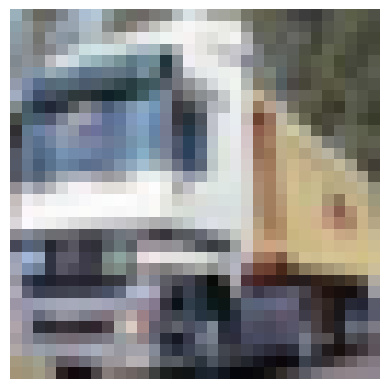

Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


'truck'

In [18]:
idx = 1
X = X_train[idx:idx+1]
show(X)
predict(X)

In [ ]:
!kubectl logs -n kserve-demo $(kubectl get pod -n kserve-demo -l app=hello-display -o jsonpath='{.items[0].metadata.name}') 

In [31]:
from tqdm.notebook import tqdm
for i in tqdm(range(0,5000,100)):
    X = X_train[i:i+100]
    predict(X)

  0%|          | 0/50 [00:00<?, ?it/s]

Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [32]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
corruption = ['motion_blur']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

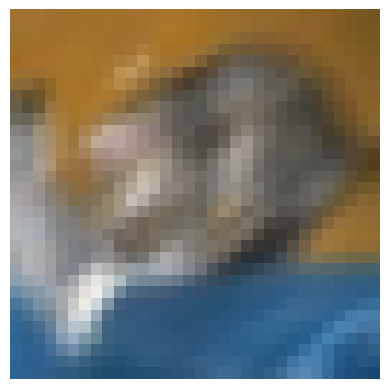

In [33]:
show(X_corr[0])

In [34]:
for i in tqdm(range(0,5000,100)):
    X = X_corr[i:i+100]
    predict(X)

  0%|          | 0/50 [00:00<?, ?it/s]

Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Predict url:https://tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com/v1/models/tfserving-cifar10:predict


/Users/aliok/script/yaml/data-science/data-science/drift-detection/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tfserving-cifar10-predictor-kserve-demo.apps.aliok-c099.serverless.devcluster.openshift.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
